# EC: Exercise 6 (Memetic algorithms vs. simple EAs)

In [2]:
import numpy as np
import numpy.random as rnd
import math
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from timeit import default_timer as timer

In [3]:
#loading in the given .txt data:
txt_data = np.loadtxt("file-tsp.txt", unpack = False)
txt_data_size = np.shape(txt_data)[0]

# loading the 48-city problem (att48) from a .txt data.
# source: http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/att48.tsp
alt_txt_data = np.loadtxt("symm_48.txt", unpack = False)[:,1:]
alt_txt_data_size = np.shape(alt_txt_data)[0]

**(a)**<br>
Evolutionary algorithm abstract base class:

In [4]:
class ABC_EA(ABC):
    
    @abstractmethod
    def __update_fitness(self):
        '''
            Update the fitness value for the current value of _d_pop.
        '''
        ...

       
    def __init__(self, pop_size, init_pop, cross_prob, mut_prob, rng):
        '''
            Initialize all the necessary values.
            Parameters:
            ----------------------------------
            pop_size: [positive int]
                Population size.
                
            init_pop: [array]
                Initial population.
                
            cross_prob: [float between 0 and 1]
                Probability for crossover to occur.
                
            mut_prob: [float between 0 and 1]
                Probability for mutation to occur.
            
            rng: [random number generator].
        
        '''
        assert 0 <= cross_prob, mut_prob <= 1
              # random number generator:
        self._d_rng = rng
              # population size:
        self._d_pop_size = pop_size
              # population:
        self._d_pop = init_pop
              # population fitness values:
        self._d_fitness = np.zeros(pop_size)
              # crossover probability:
        self._d_cross_prob = cross_prob
              # mutability probability:
        self._d_mut_prob = mut_prob
              # array containing the max fitness each epoch:
        self._d_max_fit = np.array([], dtype = float)
              # array containing the avg. fitness each epoch:
        self._d_avg_fit = np.array([], dtype = float)
              # time taken by optimization:
        self._d_time = 0.
              # updating the fitness:
        self.__update_fitness()
        
    def update_hyps(cross_prob = 'UNDEF', mut_prob = 'UNDEF'):
        '''
            Changes the hyper parameters
            Parameters:
            ----------------------------------
            cross_prob: [float between 0 and 1]
                Probability for crossover to occur.
                
            mut_prob: [float between 0 and 1]
                Probability for mutation to occur.            
        '''
        if cross_prob != 'UNDEF':
            assert 0 <= cross_prob <= 1
            self._d_cross_prob = cross_prob
        if mut_prob != 'UNDEF':
            assert 0 <= mut_prob <= 1
            self._d_mut_prob = mut_prob
            
    
    def __select(self, numb):
        '''
            Select `numb' members from the current population.
            Parameters:
            ----------------------------------
            numb: [positive int]
                Number of members to generate.
            ----------------------------------
            Returns:
                A selected number of the population.
                [Array of elements of the same type as _d_pop].
        '''
        ...

        
         # to be defined:    
    @abstractmethod
    def __crossover(self, parents):
        '''
            Perform crossover on `parents' with probability `_d_cross_prob'.
            Parameters:
            ----------------------------------
            parents: [Array of elements of the same type as _d_pop].
            ----------------------------------
            Returns:
                The children obtained by performing crossover
                [Array of elements of the same type as _d_pop].
        '''
        ...
    
    
    @abstractmethod
    def __mutate(self, children):
        '''
            Perform a mutation on `children' with probability `_d_mut_prob'.
            Parameters:
            ----------------------------------
            children: [Array of elements of the same type as _d_pop].
            ----------------------------------
            Returns:
                The mutated children obtained by applying the mutation operator
                [Array of elements of the same type as _d_pop].
        '''
        ...

    def __give_additional(self):
        '''
            Print / plot additional information, if the plot option is given in optimize.
        '''
        pass
    
    
    def optimize(self, maxiter, crit = 0, mut_prob = -1, cross_prob = -1,
                 ret = False, plot = False, title = '', time = False, time_limit = 'inf'):
        '''
            Perform the optimization algorithm, until either maxiter epochs have 
            passed, or until the absolute difference of the average fitness 
            between consecutive epochs does not change more than `crit'.
            Parameters:
            ----------------------------------
            maxiter: [positive int]
                Maximum number of iterations to perform.
                
            crit: [non-negative float]
                Stopping criterion.
                
            mut_prob: [float between 0 and 1]
                Mutation probability (for the default -1 we pick standard value).
            
            cross_prob: [float between 0 and 1]
                Crossover probability (for the default -1 we pick standard value).
                
            ret: [boolean]
                If true, we return d_avg_fit, d_max_fit, the individual with the
                highest firness and whether we stopped early.
                
            plot: [boolean]
                Decides whether we plot the progress.
                
            title: [string]
                The title of the plot.
            
            time: [bool]
                If true, prints the total time taken by the optimization.
                
            time_limit: [positive number | 'inf']
                Stops the current run when it starts to exceed time_limit.
        '''
          # start timer:
        start = timer()
        
          # check input:
        assert maxiter >= 0
        
        start_length = np.size(self._d_avg_fit)
        temp_avg_fit = np.zeros(maxiter, dtype = float)
        temp_max_fit = np.zeros(maxiter, dtype = float)
        
        stopped_at = maxiter
        crit_achieved = False
        
        if start_length > 2 and \
             np.abs(self._d_avg_fit[-1] - self._d_avg_fit[-2]) < crit:
            crit_achieved = True
            stopped_at = 0
            
          # the algorithm:
        for idx in range(maxiter):
            if crit_achieved or idx > 2 and \
                  np.abs(temp_avg_fit[idx - 1] - temp_avg_fit[idx - 2]) < crit:
                stopped_at = idx
                crit_achieved = True
                break
            
            if time_limit != 'inf' and timer() - start >= time_limit:
                stopped_at = idx
                break
                
            selected = self.__select(self._d_pop_size)
            children = self.__crossover(selected)
            self._d_pop = self.__mutate(children)
            self.__update_fitness()
            temp_max_fit[idx] = np.max(self._d_fitness)
            temp_avg_fit[idx] = np.mean(self._d_fitness)
            
          # update timer (we do not want to count the time plotting takes):
        self._d_time += timer() - start
            
        self._d_avg_fit = np.append(self._d_avg_fit, temp_avg_fit[:stopped_at])
        self._d_max_fit = np.append(self._d_max_fit, temp_max_fit[:stopped_at])
        
          # plotting:
        if plot:
            plt.title(title)
            plt.xlabel('Generation')
            plt.ylabel('Fitness')
            plt.plot(np.arange(start_length + stopped_at, dtype = int), \
                     self._d_avg_fit, label = 'Average fitness')
            plt.plot(np.arange(start_length + stopped_at, dtype = int), \
                     self._d_max_fit, label = 'Best fitness')
            plt.legend()
            plt.show()
            self.__give_additional()
            
        if time:
            print('Time taken:', self._d_time, 'seconds')
            
        best_specimen = self._d_pop[np.argmax(self._d_fitness)]
        
        if ret:    
            return self._d_avg_fit, self._d_max_fit, best_specimen, crit_achieved

In [5]:
  # Random initialization:
def RND_init(data, pop_size,  rng = rnd.default_rng()):   
    data_size = np.shape(data)[0]
              # the to be generated population:
    perms = np.zeros(pop_size, dtype=object)
              # generating the population:       
    for idx in range(pop_size): 
        perm_size1 = np.shape(data)[0]
        perms[idx] = list(rnd.choice(np.arange(perm_size1), perm_size1, replace = False))
    return perms

Defining crossover for TSP:

In [6]:
def crossover_on_perms(perm1, perm2, pos1, pos2):
    perm_len = len(perm1)
    assert 0 < pos1 < pos2 < perm_len
    
    def init_new_perm(choice):
        assert choice == 1 or choice == 2
        if choice == 1:
            perm = perm1
            
        elif choice == 2:
            perm = perm2
            
        new_perm =  [-1] * perm_len
        new_perm[pos1 : pos2] = perm[pos1 : pos2]
        return new_perm
    
    new_perm1 = init_new_perm(1)
    new_perm2 = init_new_perm(2)
    
    def fill_in_the_blanks(child_partial, other_parent):
        order = [idx % perm_len for idx in range(pos2, perm_len + pos2)]
        permute_parent = [other_parent[idx] for idx in order]
        up_to = 0
        for idx in order:
            if child_partial[idx] != -1:
                break
            for idy in range(up_to, perm_len):
                if permute_parent[idy] in child_partial[pos1 : pos2]:
                    continue
                else:
                    child_partial[idx] = permute_parent[idy]
                    up_to = idy + 1
                    break
    
    fill_in_the_blanks(new_perm1, perm2)
    fill_in_the_blanks(new_perm2, perm1)
    
    return new_perm1, new_perm2

Sanity check comparing defined function to the example from the slides:

In [7]:
list1 = [3, 5, 7, 2, 1, 6, 4, 8]
list2 = [2, 5, 7, 6, 8, 1, 3, 4]
pos1 = 2
pos2 = 6
children = crossover_on_perms(list1, list2, pos1, pos2)
print('first child =', children[0])
print('second child =', children[1])

first child = [5, 8, 7, 2, 1, 6, 3, 4]
second child = [5, 2, 7, 6, 8, 1, 4, 3]


Defining permutation for TSP:

In [8]:
def mutation_on_perms(perm, pos1, pos2):
    assert  0 <= pos1 < pos2 <= len(perm)
    
    temp_val1 = perm[pos1]
    temp_val2 = perm[pos2]
    
    perm[pos1] = temp_val2
    perm[pos2] = temp_val1
    
    return perm

Sanity check comparing defined function to the example from the slides:

In [9]:
list3 = [5, 8, 7, 2, 1, 6, 3, 4]

print(mutation_on_perms(list3, 2, 5))

[5, 8, 6, 2, 1, 7, 3, 4]


**Pure EA algorithm for TSP:**

In [10]:
class EA_TSP(ABC_EA):
    
    def __tot_distance(self, perm):
        return np.sum(np.linalg.norm(self._d_data[perm[1:]] \
                                     - self._d_data[perm[:-1]], axis = 1))
    
      # calculating the distances all at once is quicker than one at a time,
      # when applicable:
    def __tot_distance_arr(self, arr_o_perm):
        arr_o_arr = np.array(list(arr_o_perm))
        return np.sum(np.linalg.norm(self._d_data[arr_o_arr[:,1:]] \
                                     - self._d_data[arr_o_arr[:,:-1]], \
                                     axis = 2), axis = 1)
    
    @staticmethod
    def fitness_tf(x):
        return 1 / x

    
    def _ABC_EA__update_fitness(self):
        self._d_fitness = self.fitness_tf(self.__tot_distance_arr(self._d_pop))

        
    def _ABC_EA__select(self, numb):
        selected = np.zeros(numb, dtype = int)
        arr_pairs = np.zeros((numb, 2), dtype = int)
        for idx in range(numb):
            arr_pairs[idx] = self._d_rng.choice(numb, 2, replace = False)
        indexes = np.arange(numb)
        selected = np.where(self._d_fitness[arr_pairs[indexes, 0]] < \
                                self._d_fitness[arr_pairs[indexes, 1]], \
                            arr_pairs[indexes, 1], arr_pairs[indexes, 0])
        
        return self._d_pop[selected]    
        
            
    def __init__(self, data, pop_size, init_fun = RND_init, \
                 cross_prob = 0.4, mut_prob = 0.1, rng = rnd.default_rng()):
        '''
            Parameters:
            ----------------------------------
            init_fun [function : (data, pop_size, rng) |---> population]
                Should initialize the population.
                
            See base class for other parameters.
        '''
        assert callable(init_fun)
        self._d_data = data
        super().__init__(pop_size, init_fun(data, pop_size, rng), \
                         cross_prob, mut_prob,  rng)
            
            
          # perform a local optimization (none here):
    def __local_opt(self, child):
        return child
        
        
    def _ABC_EA__crossover(self, parents):
        parents_size = np.shape(parents)[0]
        perm_size = len(parents[0])
        children = parents
        to_cross = np.where(self._d_rng.binomial(1, self._d_cross_prob, \
                                                 size = parents_size))[0]
        
        for idx in range(np.size(to_cross)):
            if idx + 1 == np.size(to_cross):
                break
            posits = np.sort(self._d_rng.choice(np.arange(1, perm_size), \
                                                2, replace = False))
            children[to_cross[idx]], children[to_cross[idx + 1]] = \
                crossover_on_perms(parents[to_cross[idx]], \
                                   parents[to_cross[idx + 1]], posits[0], posits[1])
            children[to_cross[idx]] = self.__local_opt(children[to_cross[idx]])
            children[to_cross[idx + 1]] = self.__local_opt(children[to_cross[idx + 1]])
        return children
    
        
    def _ABC_EA__mutate(self, children):
        children_size = np.shape(children)[0]
        child_size = len(children[0])
        to_mutate = np.where(self._d_rng.binomial(1, self._d_mut_prob, children_size))[0]
        if np.size(to_mutate) != 0:
            for idx in to_mutate:
                posits = np.sort(self._d_rng.choice(np.arange(child_size), \
                                                    2, replace = False))
                children[idx] = mutation_on_perms(children[idx], posits[0], posits[1])
                children[idx] = self.__local_opt(children[idx])
        return children
    
    
    def _ABC_EA__give_additional(self):
        distances = self.__tot_distance_arr(self._d_pop)
        print('Average distance:', np.mean(distances))
        print('Shortest distance:', np.min(distances))


        

Testing the implementation of EA_TSP:

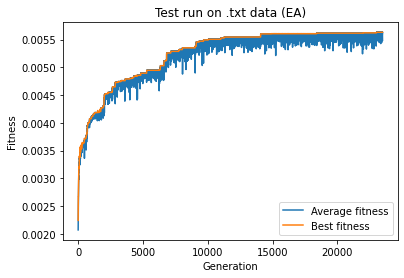

Average distance: 183.22348947788373
Shortest distance: 177.53185967749727
Time taken: 60.00131880000117 seconds


In [27]:
ev_alg = EA_TSP(txt_data, 50,  mut_prob = 0.01, cross_prob = 0.2)
ev_alg.optimize(100000, title = 'Test run on .txt data (EA)', plot = True, \
                time = True, time_limit = 60)

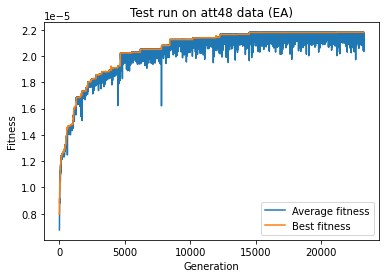

Average distance: 46155.15222518398
Shortest distance: 45858.71882554479
Time taken: 60.002020800002356 seconds


In [28]:
ev_alg = EA_TSP(alt_txt_data, 50,  mut_prob = 0.01, cross_prob = 0.2)
ev_alg.optimize(100000, title = 'Test run on att48 data (EA)', plot = True, \
                time = True, time_limit = 60)

**Defining MA for TSP:**

In [11]:
class MA_TSP(EA_TSP):

    def __init__(self, data, pop_size, init_fun = RND_init, cross_prob = 0.4, \
                 mut_prob = 0.1, opt_it = 'inf', rng = rnd.default_rng()):
        '''
            Parameters:
            ----------------------------------
            opt_int [positive integer | 'inf']:
                If `opt_int' is 'inf', then 2-opt will run untill no improvements
                are made. If `opt_int' is an integer, we will apply 2-opt, `opt_int'
                at most number of times every time we apply the local optimization.
                
            See base class for other parameters.
        '''
        super().__init__(data, pop_size, init_fun, cross_prob, mut_prob, rng)
        self._d_opt_it = opt_it
        start = timer()
        for idx in range(self._d_pop_size):
            self._d_pop[idx] = self._EA_TSP__local_opt(self._d_pop[idx])
        self._d_time += timer() - start
    
    def _EA_TSP__local_opt(self, child):
        opt_it = self._d_opt_it
        current_dist = self._EA_TSP__tot_distance(child)
        current_child = child
        data_length = len(self._d_data[:,])
          # apply 2-opt untill no improvements are made, or untill opt_it is zero:
        while True:
            if opt_it == 0:
                break

            change = False

            for idx in range(data_length):
                for idy in range(idx + 1, data_length):
                    child, new_dist = self.__two_opt_step(current_child, current_dist, \
                                                          idx, idy)
                    if current_dist - new_dist > 1e-4:
                        change = True
                        current_dist = new_dist
                        current_child = child
            if opt_it != 'inf':
                opt_it -= 1
            if not change:
                break
        return current_child
    
    
    def update_hyps(self, cross_prob = 'UNDEF', mut_prob = 'UNDEF', opt_it = 'UNDEF'):
        super().update_hyps(cross_prob = 'UNDEF', mut_prob = 'UNDEF')
        if opt_it != 'UNDEF':
            self._d_opt_it = opt_it
            
        
    def __two_opt_step(self, perm, current_dist, pos1, pos2):
        assert 0 <= pos1 < pos2 <= len(perm)
     
          # reversing has no effect:        
        if pos1 == 0 and pos2 == len(perm):
            return perm, current_dist
          # for such low dimensions, our norm is quicker than numpy's
          # probably numpy has some relativly large constant overhead.        
        def new_norm(pos1, pos2):
            newpos1 = pos1[0] - pos2[0]
            newpos2 = pos1[1] - pos2[1]
            return math.sqrt(newpos1 ** 2 + newpos2 ** 2)
        
          # exploting that the current distance is similar to the new distance (in its path)
        alt_dist = current_dist - new_norm(self._d_data[perm[pos1 - 1]], \
                                         self._d_data[perm[pos1]])          \
                        - new_norm(self._d_data[perm[pos2 - 1]],         \
                                         self._d_data[perm[pos2]])          \
                        + new_norm(self._d_data[perm[pos1 - 1]],         \
                                         self._d_data[perm[pos2 - 1]])      \
                        + new_norm(self._d_data[perm[pos1]],             \
                                         self._d_data[perm[pos2]])

        if alt_dist < current_dist:
            return perm[: pos1] + perm[pos1 : pos2][:: -1] + perm[pos2 :], alt_dist
        else:
            return perm, current_dist


Testing the implementation of MA_TSP:

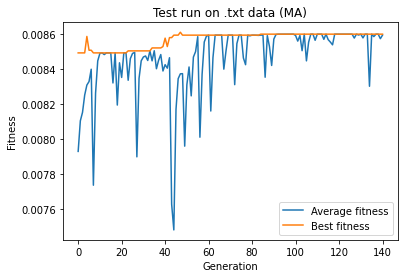

Average distance: 116.3353874435018
Shortest distance: 116.25908262823091
Time taken: 64.17778889999681 seconds


In [29]:
mm_alg = MA_TSP(txt_data, 50,  mut_prob = 0.01, cross_prob = 0.2)
mm_alg.optimize(1500, title = 'Test run on .txt data (MA)', plot = True, \
                time = True, time_limit = 60)

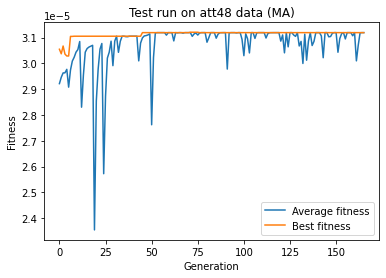

Average distance: 32061.58603760344
Shortest distance: 32061.58603760344
Time taken: 63.148562200000015 seconds


In [30]:
mm_alg = MA_TSP(alt_txt_data, 50,  mut_prob = 0.01, cross_prob = 0.2)
mm_alg.optimize(1500, title = 'Test run on att48 data (MA)', plot = True, \
                time = True, time_limit = 60)

**(b)/(c)**<br>
Function to run the tests and create the plots: <br>
Note, we shall also create plots using distance instead of fitness, as these would be easier to compare against other methods, using alternative fitness functions.

In [28]:
  # create comparative plots:
def create_data(numb_iter, title, data, maxiter, pop_size, init_fun = RND_init, \
                cross_prob = 0.2, mut_prob = 0.01, time_limit = 'inf'):
    
      # obtain results:
    def perform_runs(method_construct):
        method_avg = np.zeros(numb_iter, dtype = object)
        method_best = np.zeros(numb_iter, dtype = object)

        for idx in range(numb_iter):
            ev_alg = method_construct(data, pop_size, init_fun = init_fun, \
                                  mut_prob = mut_prob, cross_prob = cross_prob)       
            avg, best, _, _ = ev_alg.optimize(maxiter, ret = True, \
                                              time_limit = time_limit)

            method_avg[idx]  = avg
            method_best[idx] = best
            
        return method_avg, method_best
    
    EA_avg, EA_best = perform_runs(EA_TSP)
    MA_avg, MA_best = perform_runs(MA_TSP)
    
    fig1, axs1 = plt.subplots(2, 2, figsize=(12, 10), constrained_layout = True)
    fig2, axs2 = plt.subplots(2, 2, figsize=(12, 10), constrained_layout = True)
      # make subplot:
    def make_plot(axis, idx, idy, runs, header, ylabel, ytrans):
        for run in runs:
            axis[idx, idy].set_title(header + title)
            axis[idx, idy].plot(np.arange(np.size(run)),  ytrans(run), alpha = .75)
            axis[idx, idy].set_xlabel("Generations")
            axis[idx, idy].set_ylabel(ylabel)
    
    make_plot(axs1, 0, 0, EA_avg, 'EA avg fitness: ', 'Fitness', lambda x : x)
    make_plot(axs1, 1, 0, EA_best, 'EA best fitness: ', 'Fitness', lambda x : x)
    make_plot(axs1, 0, 1, MA_avg, 'MA avg fitness: ', 'Fitness', lambda x : x)
    make_plot(axs1, 1, 1, MA_best, 'MA best fitness: ', 'Fitness', lambda x : x)

    make_plot(axs2, 0, 0, EA_avg, 'EA avg distance: ', 'Distance', lambda x : 1 / x)
    make_plot(axs2, 1, 0, EA_best, 'EA best distance: ', 'Distance', lambda x : 1 / x)
    make_plot(axs2, 0, 1, MA_avg, 'MA avg distance: ', 'Distance', lambda x : 1 / x)
    make_plot(axs2, 1, 1, MA_best, 'MA best distance: ', 'Distance', lambda x : 1 / x)


Performing the tests for the data given in the .txt file: <br>
Note that we use a population size of 50, a crossover probability of 1/5 and a mutation probability of 1/100.
The probabilities were chosen by trying various values, and seeing what led to a good performance.
The population size was chosen to be 50, as for higher values, running the MA for 1500 iterations would take a very long time.

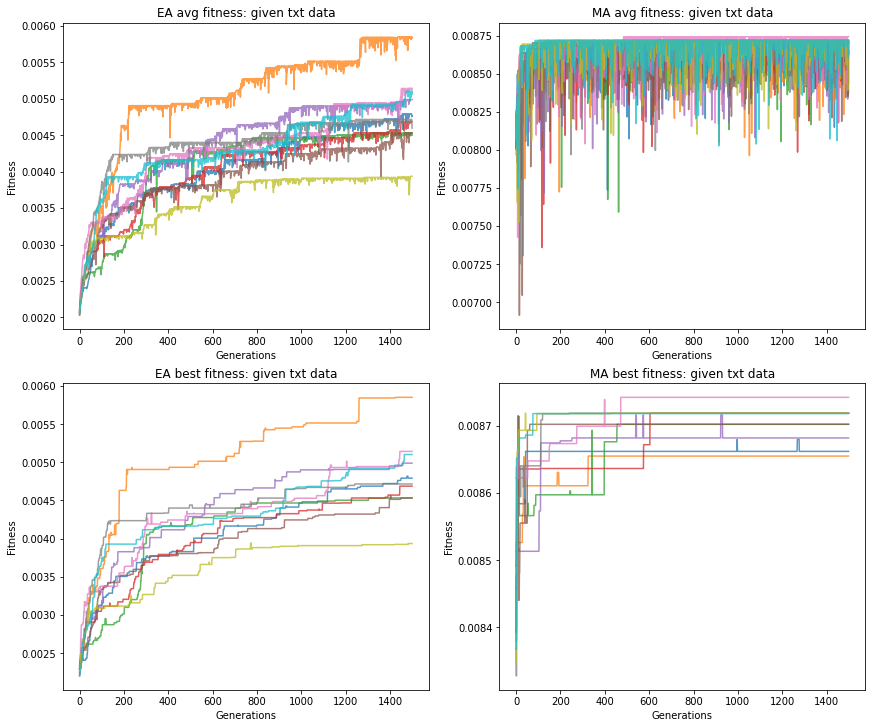

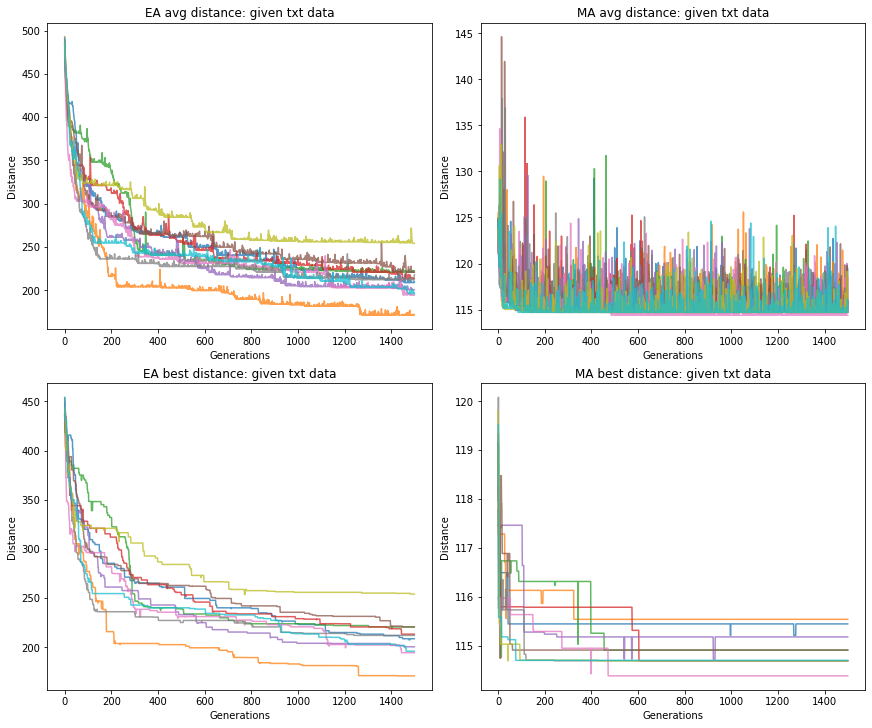

In [30]:
create_data(10, 'given txt data', txt_data, 1500, 50)

Performing the tests for the att48 data:

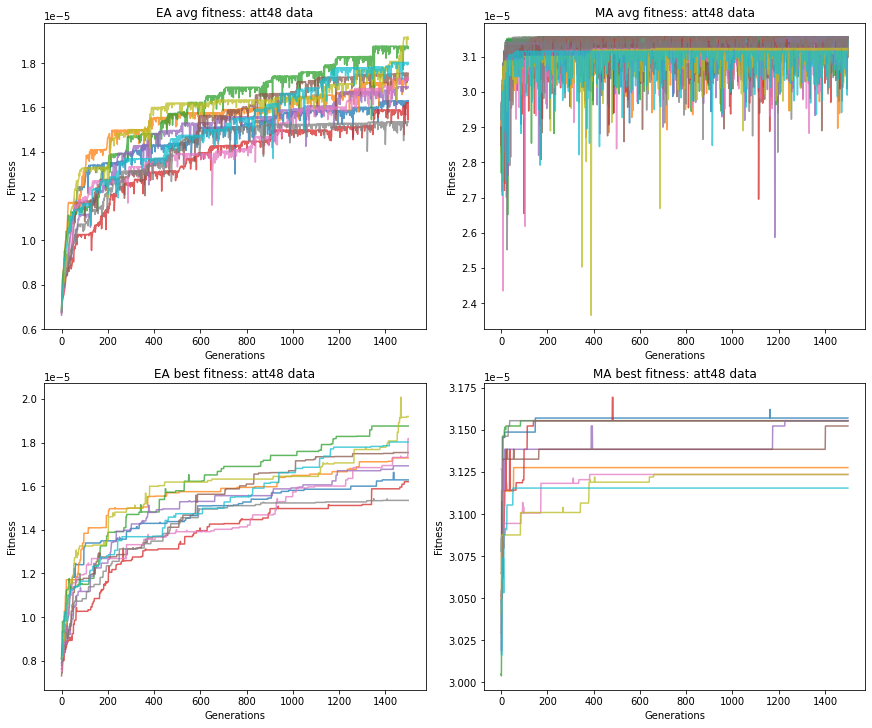

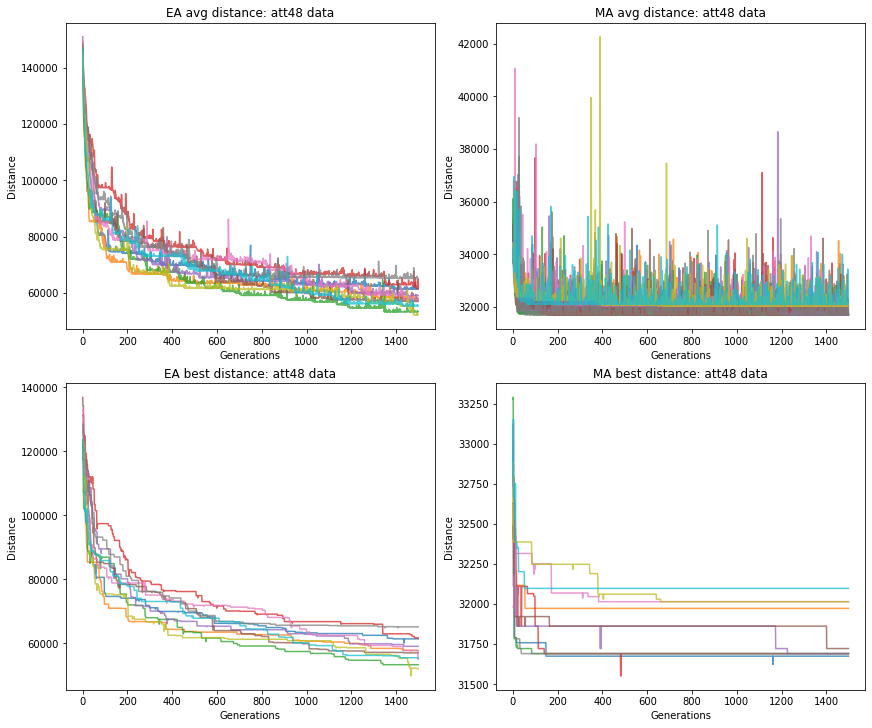

In [31]:
create_data(10, 'att48 data', alt_txt_data, 1500, 50)

**(d)**

From the above two plots we would conclude that the memetic algorithm outperformes the evolutionary algorithm quite considerably.
We see that both the averge and best distance is lower for the memetic algorithm, and that the algorithm converges in fewer iterations.

**(e)**

The comparison is not fair.
The memetic algorithm takes considerably longer in computation time per generation (See the previous test runs, where the run time was set to 60 seconds. We saw that the EA could perform 20000 iterations in the same time the MA could perform 140). <br>
Then, when only comparing the performance for a fixed number of iterations, is not surprising that the memetic algorithm then performs better, as we strictly work with populations which have been optimized by the local search, i.e. the population is artificially made fitter.
A fair test would then be the following:
Fix an amount of computation time.
Find, in some structured way, the best hyper parameters (population size / probabilities) for each method individually.
Then perform a number of runs for each algorithm for the predermined computation time, using the, for each method, chosen hyperparameters. <br>
(Ideally, we'd also have more runs, and determine the mean and standard deviation of the final values for each method)

**(f)**

Literature suggests that memetic algorithm perform better that pure Genetic algorithms.
For example: <br>
In \`A Memetic Algorithm for the Generalized Traveling Salesman Problem', by Gregory Gutin and Daniel Karapetyan, it is stated that: <br>
"*It appears that the only metaheuristic algorithms that can compete with Lin-Kirnighan-based local search for TSP are memetic algorithms that combine powers of genetic and local search algorithms.*" <br>
<br>
In \`Memetic Algorithms for the Traveling Salesman Problem', by Peter Merz and Bernd Freisleben, it is stated that: <br>
"*(...) many researchers incorporated greedy choices into their recombination operators and/or used a local improvement technique to achive better results. The use of local search after the application of a recombination operator can compensate for the disruptive effects implicit mutations.*" (by implicit mutations, the introduction of foreign edges are meant). <br>
<br>
However, it should be noted that the kind of crossover/mutation operators should be tuned to the local search used, as stated in \`A Review of Memetic Algorithm and its Application in Traveling Salesman
Problem', by Rajiv Kumar and Minakshi Memoria.
Here it is stated that: <br>
"*The performance of the Memetic algorithms
depends upon its parameters i.e. crossover operator,
population size, mutation, selection, and local search.
Thus new genetic operator and local search technique
need to be built in order to improve the algorithm for
TSP problems.*"

## Bonus:

Initially we had not used tournament of size 2 as a selection method, but instead used a probabilistic selection with a different fitness function. <br>
We mention this as the performance is similar in terms of qualitivly, but is computationally more efficient for the EA, but less so for the MA. <br>
We demonstrate this below:

In [18]:
class EA_TSP_alt(EA_TSP):
    @staticmethod
    def fitness_tf(x):
        return (1000 / x) ** 5
    
    
    def _ABC_EA__select(self, numb):
        return self._d_rng.choice(self._d_pop, numb, \
                    p = (self._d_fitness) / np.sum(self._d_fitness))

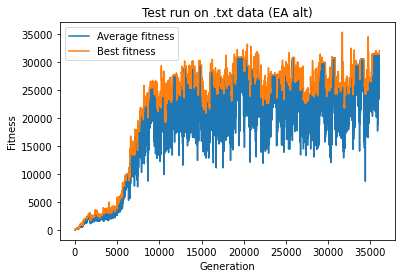

Average distance: 128.64401738569705
Shortest distance: 125.54090178649867
Time taken: 60.00046890000158 seconds


In [34]:
em_alg_alt = EA_TSP_alt(txt_data, 50,  mut_prob = 0.01, cross_prob = 0.2)
em_alg_alt.optimize(1000000, title = 'Test run on .txt data (EA alt)', plot = True, \
                    time = True, time_limit = 60)

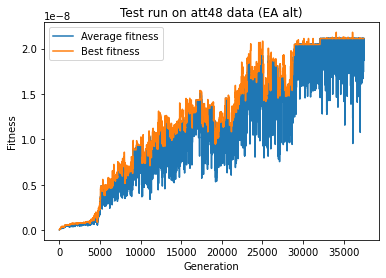

Average distance: 34285.252538379835
Shortest distance: 34285.252538379835
Time taken: 60.0004506999976 seconds


In [35]:
em_alg_alt = EA_TSP_alt(alt_txt_data, 50,  mut_prob = 0.01, cross_prob = 0.2)
em_alg_alt.optimize(10000000, title = 'Test run on att48 data (EA alt)', plot = True, \
                    time = True, time_limit = 60)

In [20]:
class MA_TSP_alt(MA_TSP):
    @staticmethod
    def fitness_tf(x):
        return (1000 / x) ** 5
    
    
    def _ABC_EA__select(self, numb):
        return self._d_rng.choice(self._d_pop, numb, \
                    p = (self._d_fitness) / np.sum(self._d_fitness))

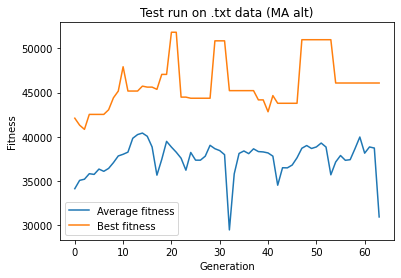

Average distance: 132.30369976992034
Shortest distance: 116.76400772189679
Time taken: 64.21265759999733 seconds


In [36]:
mm_alg_alt = MA_TSP_alt(txt_data, 50,  mut_prob = 0.01, cross_prob = 0.2)
mm_alg_alt.optimize(1500, title = 'Test run on .txt data (MA alt)', plot = True, \
                    time = True, time_limit = 60)

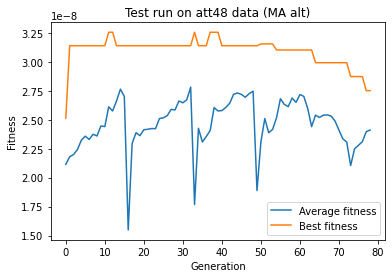

Average distance: 33417.56872154583
Shortest distance: 32516.088193752967
Time taken: 63.89333899999838 seconds


In [37]:
mm_alg_alt = MA_TSP_alt(alt_txt_data, 50,  mut_prob = 0.01, cross_prob = 0.2)
mm_alg_alt.optimize(1500, title = 'Test run on att48 data (MA alt)', plot = True, \
                    time = True, time_limit = 60)